### Load in and clean up data

In [26]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import statsmodels.formula.api as smf
import pgeocode

In [2]:
client = Socrata("health.data.ny.gov", None)

# First 50,000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tg3i-cinn", limit=50000)

# Convert to pandas DataFrame
nyd2019_50k = pd.DataFrame.from_records(results)
nyd2019_50k.shape
nyd2019_50k.head(3)

,hospital_service_area,hospital_county,operating_certificate_number,permanent_facility_id,facility_name,age_group,zip_code_3_digits,gender,race,ethnicity,...,apr_severity_of_illness,apr_risk_of_mortality,apr_medical_surgical,payment_typology_1,payment_typology_2,emergency_department_indicator,total_charges,total_costs,birth_weight,payment_typology_3
0,New York City,Bronx,7000006,001169,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Extreme,Medical,Medicare,Medicaid,Y,320922.43,60241.34,NaN,NaN
1,New York City,Bronx,7000006,001169,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,Y,61665.22,9180.69,NaN,NaN
2,New York City,Bronx,7000006,001168,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,F,Other Race,Spanish/Hispanic,...,Minor,Minor,Surgical,Medicaid,NaN,N,42705.34,11366.50,NaN,NaN


In [3]:
#go from county to latitiude longitude
nomi = pgeocode.Nominatim('us')

nomi.query_location("Bronx", top_k=3)
## might need to go from inputted lat/long in the webapp to county name

,country_code,postal_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
25168,US,10451,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8222,-73.9217,4.0
25169,US,10452,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8376,-73.9216,4.0
25170,US,10453,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8520,-73.9129,4.0


### Create regression models

In [6]:
# predict total charges and length of stay from demographic variables

## length of stay

#remove rows where length of stay >120
nyd2019_los = nyd2019_50k[~(nyd2019_50k['length_of_stay'] == '120 +')]
#make length of stay variable numeric
nyd2019_los['length_of_stay'] = pd.to_numeric(nyd2019_los['length_of_stay'])

los_model = smf.ols(formula='length_of_stay ~ C(hospital_county) + C(age_group) + C(gender) + C(race) + C(ethnicity) + C(type_of_admission) + C(payment_typology_1)', data=nyd2019_los).fit()
print(los_model.summary())

/tmp/ipykernel_632071/2080316540.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyd2019_los['length_of_stay'] = pd.to_numeric(nyd2019_los['length_of_stay'])


                            OLS Regression Results                            
Dep. Variable:         length_of_stay   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     54.58
Date:                Sat, 13 May 2023   Prob (F-statistic):               0.00
Time:                        17:29:22   Log-Likelihood:            -1.7448e+05
No. Observations:               49668   AIC:                         3.490e+05
Df Residuals:                   49625   BIC:                         3.494e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [7]:
##total charges

#converting total charges column to numeric values
nyd2019_50k['total_charges'] = pd.to_numeric(nyd2019_50k['total_charges'])
#dropping rows from the dataframe where total charges is greater than $400000
nyd2019_charges = nyd2019_50k[nyd2019_50k['total_charges'] <= 400000]

charges_model = smf.ols(formula='total_charges ~ C(hospital_county) + C(age_group) + C(gender) + C(race) + C(ethnicity) + C(type_of_admission) + C(payment_typology_1)', data=nyd2019_charges).fit()
print(charges_model.summary())

                            OLS Regression Results                            
Dep. Variable:          total_charges   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     204.8
Date:                Sat, 13 May 2023   Prob (F-statistic):               0.00
Time:                        17:29:39   Log-Likelihood:            -6.0534e+05
No. Observations:               48792   AIC:                         1.211e+06
Df Residuals:                   48749   BIC:                         1.211e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [9]:
import joblib

#uncomment these lines to get it to save the models to your computer, it just won't let me push these to github because the file size is too big

joblib.dump(los_model, "los_model.pkl")
joblib.dump(charges_model, "charges_model.pkl")

['charges_model.pkl']

### Create streamlit app

In [10]:
import streamlit as st

#los_model = joblib.load("los_model.pkl")
#charges_model = joblib.load("charges_model.pkl")

def main():
    st.title("Estimate length of hospital stay and total charges based on location and demographic variables")
    
    # Create dropdown menus for user input
    input_features = ["Hospital County", "Age Group", "Sex", "Race", "Ethnicity", "Type of Admission", "Form of Payment"]
    options = {
        "Hospital County": ["Bronx", "Cayuga", "Columbia", "Delaware", "Kings", "Manhattan", "Monroe", "Nassau", "Onondaga", "Ontario", "Orange", "Otsego", "Queens", "Rockland", "Steuben", "Sullivan", "Westchester"],
        "Age Group": ["18 to 29", "30 to 49", "50 to 69", "70 to 79"],
        "Sex": ["Male", "Female"],
        "Race": ["Multi-racial", "Other Race", "White"],
        "Ethnicity": ["Not Spanish/Hispanic", "Spanish/Hispanic", "Unknown"],
        "Type of Admission": ["Emergency", "Newborn", "Not Available", "Trauma", "Urgent"],
        "Form of Payment": ["Department of Corrections", "Federal/State/Local/VA", "Managed Care, Unspecified", "Medicaid", "Medicare", "Miscellaneous/Other", "Private Health Insurance", "Self-Pay"]
    }
    user_inputs = [st.selectbox(f"Select {feature}", options=options[feature], key=feature) for feature in input_features]
    
    # Process user input and run the regression model
    if st.button("Predict Length of Stay and Total Charges"):
        # Convert user inputs to a DataFrame or the required format for the model
        input_data = pd.DataFrame([user_inputs], columns=input_features)
        
        # Apply any necessary preprocessing to the input data
        
        # Make predictions using the pre-trained model
        predict_stay = los_model.predict(input_data)
        predict_charges = charges_model.predict(input_data)
        
        # Display the predictions
        st.write("Predicted Length of Stay:")
        st.write(predict_stay)
        st.write("Predicted Total Charges:")
        st.write(predict_charges)
        
        # You can also display additional information or visualizations based on the predictions
        
# Run the app
if __name__ == "__main__":
    main()

  command:

    streamlit run /opt/tljh/user/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-05-13 17:30:29.657 
  command:

    streamlit run /opt/tljh/user/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [57]:
import pandas as pd
from sodapy import Socrata
import statsmodels.formula.api as smf
import pgeocode

client = Socrata("health.data.ny.gov", None)

# First 50,000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tg3i-cinn", limit=50000)

# Convert to pandas DataFrame
nyd2019_50k = pd.DataFrame.from_records(results)
nyd2019_50k.shape

# predict total charges and length of stay from demographic variables

## length of stay

#remove rows where length of stay >120
nyd2019_los = nyd2019_50k[~(nyd2019_50k['length_of_stay'] == '120 +')]
#make length of stay variable numeric
nyd2019_los['length_of_stay'] = pd.to_numeric(nyd2019_los['length_of_stay'])

/tmp/ipykernel_646795/3871896388.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
nyd2019_50k['total_charges'] = pd.to_numeric(nyd2019_50k['total_charges'])

#stats = (county_df["total_charges"]).describe()
#print(stats)

#(county_df["total_charges"]).min()
#(county_df["total_charges"]).max()

,hospital_service_area,hospital_county,operating_certificate_number,permanent_facility_id,facility_name,age_group,zip_code_3_digits,gender,race,ethnicity,...,apr_severity_of_illness,apr_risk_of_mortality,apr_medical_surgical,payment_typology_1,payment_typology_2,emergency_department_indicator,total_charges,total_costs,birth_weight,payment_typology_3
0,New York City,Bronx,7000006,001169,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Extreme,Medical,Medicare,Medicaid,Y,320922.43,60241.34,NaN,NaN
1,New York City,Bronx,7000006,001169,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,Y,61665.22,9180.69,NaN,NaN
2,New York City,Bronx,7000006,001168,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,F,Other Race,Spanish/Hispanic,...,Minor,Minor,Surgical,Medicaid,NaN,N,42705.34,11366.50,NaN,NaN
3,New York City,Bronx,7000006,003058,Montefiore Med Center - Jack D Weiler Hosp of ...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Major,Medical,Medicare,Medicaid,Y,72700.17,12111.75,NaN,NaN
4,New York City,Bronx,7000006,001169,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Medicare,Medicaid,Y,55562.51,8339.72,NaN,NaN


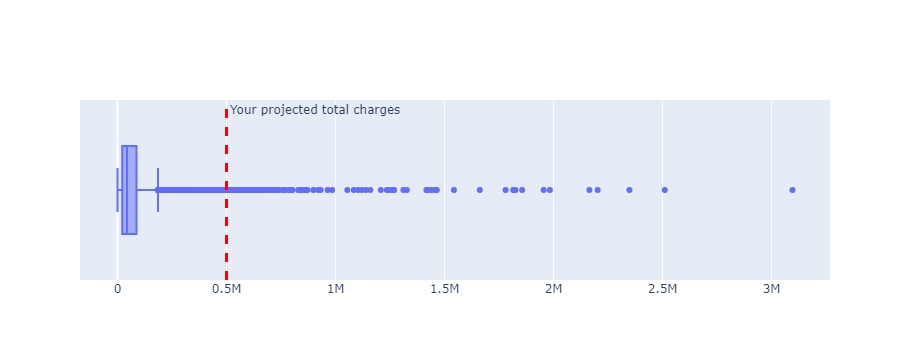

In [82]:
import plotly.express as px
import plotly.graph_objects as go

county_df = nyd2019_50k[nyd2019_50k["hospital_county"] == input_data['hospital_county'].iloc[0]]
tot_charges_df = county_df['total_charges']
# mock inputs to generate example graph
#county_df = nyd2019_50k[nyd2019_50k["hospital_county"] == "Bronx"]
#predict_charges = 500000

fig = go.Figure()
fig.add_trace(go.Box(x=tot_charges_df, orientation="h"))
fig.add_vline(x=predict_charges, line_width=3, line_dash="dash", line_color="red", annotation=dict(text="Your projected total charges"))
fig.update_yaxes(showticklabels=False)
fig.show()
